# Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm

End-of-semester project for *Advanced Statistics for Physics Analysis*, academic year 2023/2024, by
- Maria Camila Paris Diaz (2106186)
- Gabriele Poccianti (2106713)
- Laura Schulze (2122311)

In [ ]:
# install packages otherwise unavailable in colab
install.packages(c("bnlearn", "bnstruct", "arules"))
install.packages("BiocManager")
BiocManager::install("Rgraphviz")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘igraph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'Rgraphviz'

also installing the dependencies ‘BiocGenerics’, ‘graph’


Old packages: 'httr2'



Library imports:

In [ ]:
# Load necessary libraries
suppressPackageStartupMessages(library("tidyverse"))
library("bnlearn") %>% suppressPackageStartupMessages()
library("bnstruct") %>% suppressPackageStartupMessages()
library("Rgraphviz") %>% suppressPackageStartupMessages()
library("arules") %>% suppressPackageStartupMessages()
library("digest") %>% suppressPackageStartupMessages()


## The K2 algorithm

The K2 algorithm [[Cooper/Herskovits](https://doi.org/10.1007/BF00994110)] is a heuristic search-method to find  the most probable Bayesian belief-network structure, given a database of records. It assumes an ordering of the attributes, where, if attribute $x_i$ precedes $x_j$ in the order, structures with an arc from $x_j$ to $x_i$ (so $x_i$ being a parent of $x_j$) are not allowed. Additionally, equal priors are assumed for all the allowed belief network structures that are possible.

The algorithm can be described as follows:

**Input:**  A set of nodes $n$, an ordering of the nodes,  an upper bound $u$ on the number of parents a node may have, and a database $D$ containing $m$ cases.

**Output:** For each node, a printout of the parents of the node.

$$
\begin{array}{rl}
1. & \textbf{procedure} \ \text{K2}\\
2. & \textbf{for} \; i \gets 1 \; \textbf{to} \; n \; \textbf{do} \\
3. & \quad \pi_i \gets \emptyset \\
4. & \quad P_{\text{old}} \gets g(i, \pi_i) \; \{ \text{scoring function} \} \\
5. & \quad \text{OKToProceed} \gets \textbf{true} \\
6. & \quad \textbf{while} \; \text{OKToProceed} \; \textbf{and} \; |\pi_i| < u \; \textbf{do} \\
7. & \quad \quad \text{Let} \; z \; \text{be the node in Pred}(x_i) - \pi_i \; \text{that maximizes} \; g(i, \pi_i \cup \{z\}) \\
8. & \quad \quad P_{\text{new}} \gets g(i, \pi_i \cup \{z\}) \\
9. & \quad \quad \textbf{if} \; P_{\text{new}} > P_{\text{old}} \; \textbf{then} \\
10. & \quad \quad \quad P_{\text{old}} \gets P_{\text{new}} \\
11. & \quad \quad \quad \pi_i \gets \pi_i \cup \{z\} \\
12. & \quad \quad \textbf{else} \\
13. & \quad \quad \quad \text{OKToProceed} \gets \textbf{false} \\
14. & \quad \textbf{end while}\\
15. & \quad \textbf{write}(\text{'Node:'},\, x_i,\, \text{'Parents of this node:'}, \, \pi_i) \\
16. & \textbf{end for}\\
17. & \textbf{end} \; \text{K2}\\
\end{array}
$$


### The scoring function $g(i, \pi_i)$
The scoring function $g(i, \pi_i)$ for the K2 algorithm as described in [[Ruiz](http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf)] is defined as
$$
g(i, \pi_i) = \prod^{q_i}_{j=1}\frac{\left(r_i-1\right)!}{\left(N_{ij} + r_i -1\right)!} \prod^{r_i}_{k=1}\alpha_{ijk}! \ ,
$$
where
- $\pi_i$: set of parents of $i$-th node, here called $x_i$
- $q_i = |\phi_i|$
- $\phi_i$: list of all possible instantiations of the parents of $x_i$ in database $D$. That is, if $p_1, \dots , p_s$ are the parents of $x_i$ then $\phi_i$ is the Cartesian product $\{v_1^{p_1}, \dots, v_{r_{p_1}}^{p_1}\}\times \dots \times\{v_1^{p_s}, \dots, v_{r_{p_s}}^{p_s}\}$ of all the possible values of attributes $p_1$ through $p_s$.
- $r_i = |V_i|$
- $V_i$: list of all possible values of the attribute $x_i$
- $\alpha_{ijk}$: number of cases (i.e. instances) in $D$ in which the attribute $x_i$ is instantiated with its $k$th value, and the parents of $x_i$ in $\pi_i$ are instantiated with the $j$th instantiation in $\phi_i$.
- $N_{ij} = \sum^{r_i}_{k=1}\alpha_{ijk}$. That is, the number of instances in the database in which the parents of $x_i$ in $\pi_i$ are instantiated with the $j$th instantiation in $\phi_i$.

The scoring function was implemented as follows:

In [ ]:
# k2 scoring function
k2_score <- function(node, parents, df) {

    # r: number of possible values for node
    r <- nlevels(df[[node]])

    # handle case of no parents:
    # (which we assume if parents has length 0)
    # ignore the 'j'
    if (length(parents) == 0) {
        # get all possible instantiations
        instantiations <- df %>%
            group_by(across(all_of(node))) %>%
            summarize(counts=n(), .groups='drop') %>%
            mutate(factorials=factorial(counts)) # to calculate alpha_i_k

        N <- sum(instantiations$counts)
        alpha <- prod(instantiations$factorials)
        numerator <- alpha*(factorial(r-1))
        denominator <- factorial(N+r-1)

    }
    else {

        # q:  total number of possible combinations for parent nodes
        q <- prod(sapply(df[parents], nlevels))

        # get all possible instantiations
        instantiations <- df %>%
            group_by(across(all_of(c(node, parents)))) %>%
            summarize(counts=n(), .groups='drop') %>%
            mutate(factorials=factorial(counts)) # to calculate alpha_ijk

        # get all possible instantiations of parents
        instantiations.parents <- instantiations %>%
            group_by(across(all_of(parents))) %>%
            summarize(N=sum(counts), .groups='drop') %>% # to calculate N_ij
            mutate(d = factorial(N+r-1))

        alpha <- prod(instantiations$factorials)
        numerator <- alpha*(factorial(r-1))^q
        denominator <- prod(instantiations.parents$d)
    }
    score <- numerator/denominator
    return(score)

}


To improve the run-time speed of K2 and avoid the computation of large factorials, the logarithm of the scoring function  $\log{\left(g(i,\pi_i)\right)}$ can be used instead. Computing the logarithmic version relies on addition and subtraction instead:
$$
\begin{align}
\log{\left(g(i,\pi_i)\right)} &= \log{\left(\prod^{q_i}_{j=1}\frac{\left(r_i-1\right)!}{\left(N_{ij} + r_i -1\right)!} \prod^{r_i}_{k=1}\alpha_{ijk}! \right)} \\
&= \sum^{q_i}_{j=1} \log{ \left( \frac{\left(r_i-1\right)!}{\left(N_{ij} + r_i -1\right)!} \prod^{r_i}_{k=1}\alpha_{ijk}!  \right) } \\
&= \sum^{q_i}_{j=1} \left[ \log{\left(\left(r_i-1\right)!\right)} - \log{\left(\left(N_{ij} + r_i -1\right)! \right)} + \log{\left( \prod^{r_i}_{k=1}\alpha_{ijk}! \right)} \right] \\
&= \sum^{q_i}_{j=1} \left[ \sum^{r_i-1}_{l=1} \log{l} - \sum^{N_{ij} + r_i -1}_{m=1} \log{m} + \sum^{r_i}_{k=1} \sum^{\alpha_{ijk}}_{n=1}\log{n} \right]
\end{align}
$$

In [ ]:
# logarithmic version of the scoring function
k2_score.log <- function(node, parents, df) {

    # r: number of possible values for node
    r <- nlevels(df[[node]])

    # handle case of no parents:
    # (which we assume if parents has length 0)
    # ignore the 'j'
    if (length(parents) == 0) {
        # get all possible instantiations
        instantiations <- df %>%
            group_by(across(all_of(node))) %>%
            summarize(counts=n(), .groups='drop') %>%
            mutate(c=map_dbl(counts, ~ sum(log(1:.x))))

        N <- sum(instantiations$counts)

        # calculate the summands
        A <- sum(log(1:(r-1)))
        B <- sum(log(1:(N+r-1)))
        C <- sum(instantiations$c)
    }
    else {
        # q:  total number of possible combinations for parent nodes
        q <- prod(sapply(df[parents], nlevels))

        # get all possible instantiations
        instantiations <- df %>%
            group_by(across(all_of(c(node, parents)))) %>%
            summarize(counts=n(), .groups='drop') %>%
            mutate(c=map_dbl(counts, ~ sum(log(1:.x)))) #

        # get all possible instantiations of parents
        instantiations.parents <- instantiations %>%
            group_by(across(all_of(parents))) %>%
            summarize(N=sum(counts), .groups='drop') %>%
            mutate(b = map_dbl(N, ~ sum(log(1:(.x+r-1)))))

        # calculate the summands
        A <- q*sum(log(1:(r-1)))
        B <- sum(instantiations.parents$b)
        C <- sum(instantiations$c)
    }
    score <- A - B + C
    return(score)
}

The K2 algorithm was implemented as follows, using the custom score function (either normal or logarithmic version):

In [ ]:
k2_algorithm <- function(data, node_order, max_parents=3, useLogScore=TRUE) {

    # select either regular or logarithmic scoring function
    if (useLogScore){
        score <- k2_score.log
    }
    else {
        score <- k2_score
    }

    # Initialize an empty Bayesian network with nodes in the given order
    bn <- empty.graph(node_order)

    # Iterate over each node in the given order
    for (node in node_order) {
        # Initialize an empty set of parents for the current node
        parents <- character(0)
        # Compute the initial score of the current network
        best_score <- score(node, parents, data)

        # Try adding parents while the number of parents is less than max_parents
        while (length(parents) < max_parents) {
            best_candidate <- NULL
            best_candidate_score <- best_score

            # Evaluate each potential new parent
            for (candidate_parent in node_order[1:which(node_order==node)]) {
                if (!candidate_parent %in% parents && candidate_parent != node) {
                    # Temporarily add the candidate parent and compute the new score
                    test_bn <- set.arc(bn, from = candidate_parent, to = node)
                    candidate_score <- score(node, c(parents, candidate_parent), data)

                    # Check if the new score is better than the best score found so far
                    if (candidate_score > best_candidate_score) {
                        best_candidate <- candidate_parent
                        best_candidate_score <- candidate_score
                    }
                }
            }

            # If a best candidate parent is found, add it to the network
            if (!is.null(best_candidate)) {
                bn <- set.arc(bn, from = best_candidate, to = node)
                parents <- c(parents, best_candidate)
                parents(bn, node) <- parents
                best_score <- best_candidate_score
            } else {
                break  # No better parent found, stop adding parents
            }
        }
    }

    # Return the learned Bayesian network and the its score
    return(bn)
}

### Node ordering
As previously mentioned the K2 algorithm uses a node ordering to build the network topology in a strictly hierarchical way. This dramatically limits the number of possible configurations (decreasing the computational time), but also makes it less feasible to encounter structures close to the ground truth.

To overcome this problem a randomized algorithm has been implemented.
For $t$ iterations a random order of the variables is generated, then the associated network is created using the K2 algorithm. Finally the network with the highest K2 score is given as output.

In [ ]:
rsearch <- function(data, node_order, t=100, max_parents=3, plot=FALSE) {

   n <- length(node_order)
   t <- min(t, factorial(n))

  score <- -Inf
  best_score <- score

  used_permutations <- new.env(hash = TRUE, parent = emptyenv())  # Use an environment to store unique permutations

  for (k in 1:t) {
    cat('Running iteration #', k, '...\n')
    flush.console()

    repeat {
      node_order_sample <- sample(node_order)  # Sample a permutation
      perm_hash <- digest(node_order_sample)  # Generate a hash of the permutation

      if (!exists(perm_hash, envir = used_permutations)) {
        assign(perm_hash, TRUE, envir = used_permutations)  # Mark the permutation as used
        break
      }
    }

     node_order <- node_order_sample

    bn <- k2_algorithm(data, node_order, max_parents=max_parents)

    if (plot) {
      graphviz.plot(bn, main=sprintf("node order: %s", paste(node_order, collapse=', ')))
    }

    score <- sum(sapply(nodes(bn), function(N) {k2_score.log(N, parents(bn, N), data)}))

    if(score>best_score) {
            best_score <- score
            bn_best <- bn
            order_best <- node_order
        }
  }
  return(list(score=best_score, bn=bn_best, node_order=order_best))
}

## Test Data Sets
To test the implementation of the K2 algorithm and evaluate its performance, it is used on three test data sets of varying sizes, each generated from a known Bayesian Network structure:
- RUIZ Dataset: 3 nodes, 2 arcs, 10 records
- ASIA Dataset: 8 nodes, 8 arcs, using 5000 records
- CHILD Dataset: 20 nodes, 25 arcs, using 5000 records

The network structures found through the implemented K2 algorithm are evaluated in comparison with the respective ground truth.
Furthermore, the results of the K2 implementation are compared to those of structure-learning methods implemented in the `bnlearn` library.

### RUIZ dataset
(Node: start by showing the ground truth?)
The RUIZ dataset consists of 10 records of 3 attributes $x_1$, $x_2$, $x_3$. It was generated by [[Cooper/Herskovits 1992]](https://doi.org/10.1007/BF00994110) and further used in [[Ruiz]](http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf) to illustrate the K2 algorithm. The data are generated from a Bayesian network with the structure shown below:

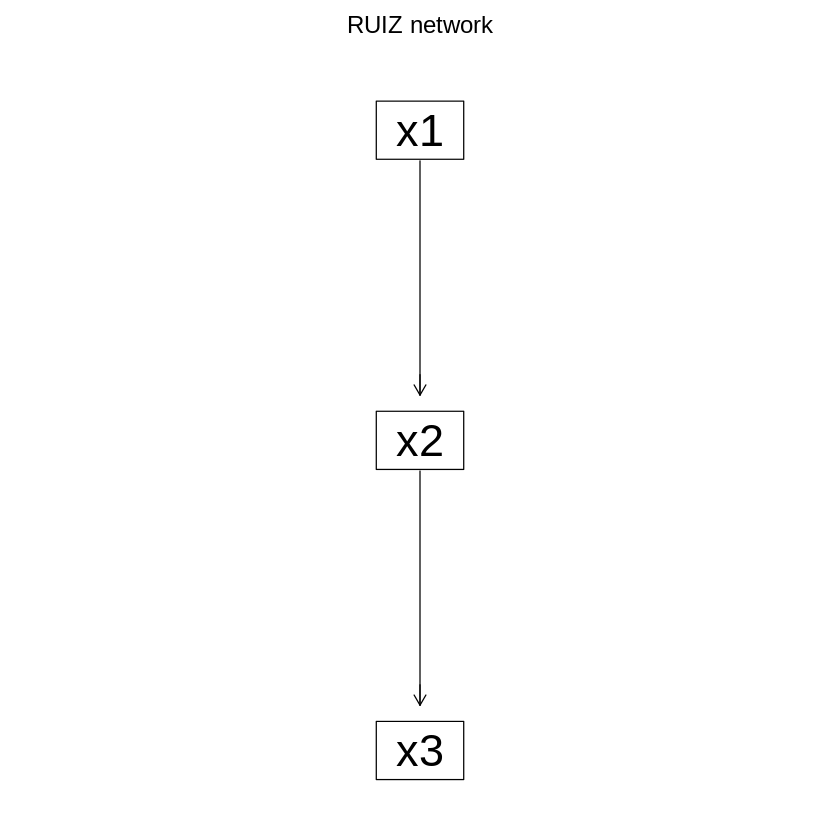

In [ ]:
# Create the dataset
data_ruiz <- data.frame(
  x1 = as.factor(c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0)),
  x2 = as.factor(c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0)),
  x3 = as.factor(c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0))
)

# Define node order
node_order_ruiz <- names(data_ruiz)

#ground truth
dag_ruiz = model2network("[x1][x2|x1][x3|x2]")
graphviz.plot(dag_ruiz,main="RUIZ network")

In [ ]:
# define maximum number of parents
# keep at 3, which is the default for our rsearch() function
max_parents=3

# use self-implemented K2 algorithm with randomized node orderings
results <- rsearch(data=data_ruiz, node_order=node_order_ruiz)
scores_ruiz <- results$score
bn_k2_ruiz <- results$bn

Running iteration # 1 ...
Running iteration # 2 ...
Running iteration # 3 ...
Running iteration # 4 ...
Running iteration # 5 ...
Running iteration # 6 ...


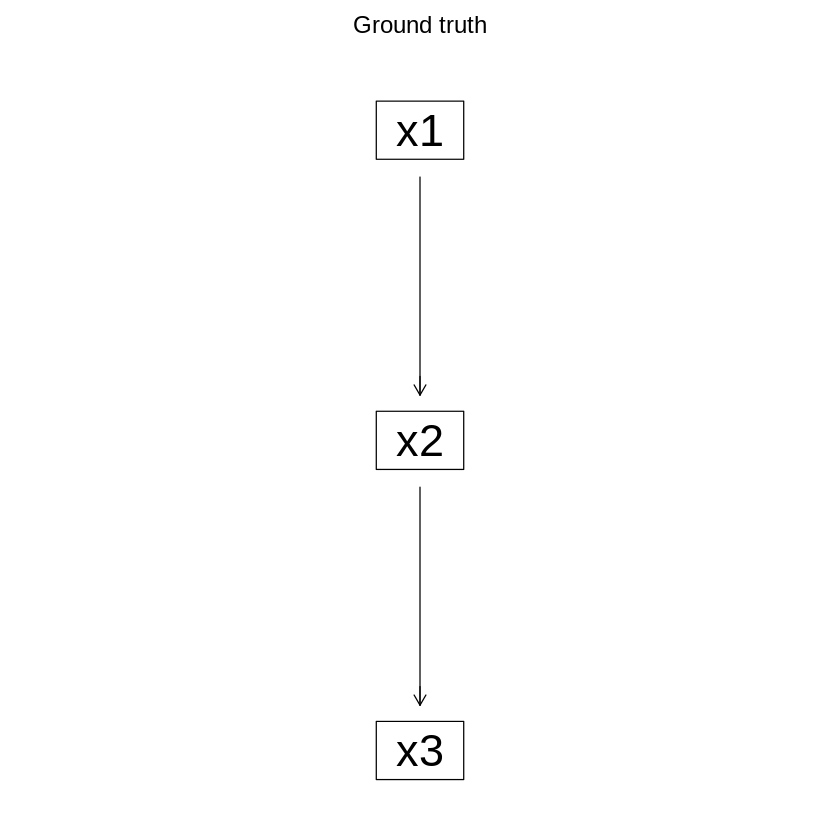

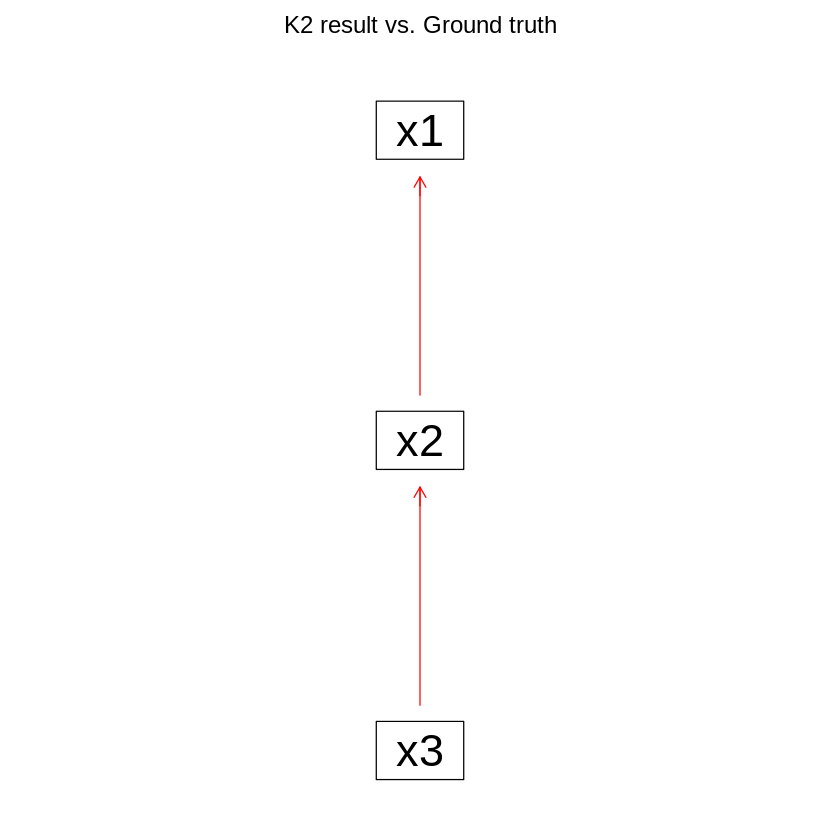

In [ ]:
# plot and compare to ground truth
graphviz.compare(dag_ruiz, bn_k2_ruiz, main=c("Ground truth", "K2 result vs. Ground truth"))

Warning message in check.maxp(misc.args$maxp, data = x):
“maximum number of parents should be lower than the number of nodes, the limit will be ignored.”


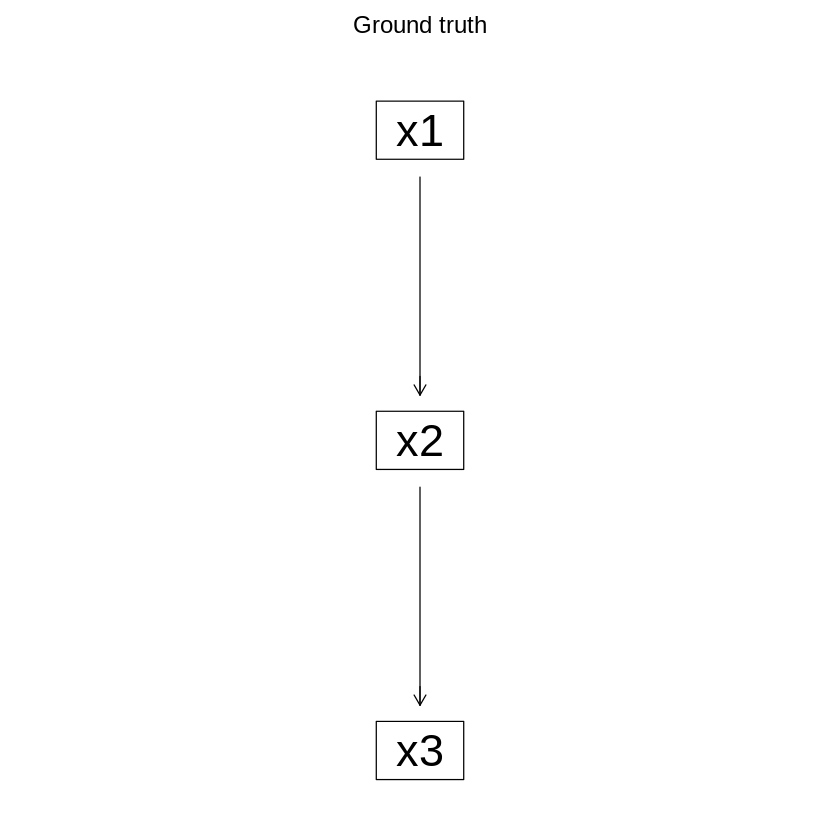

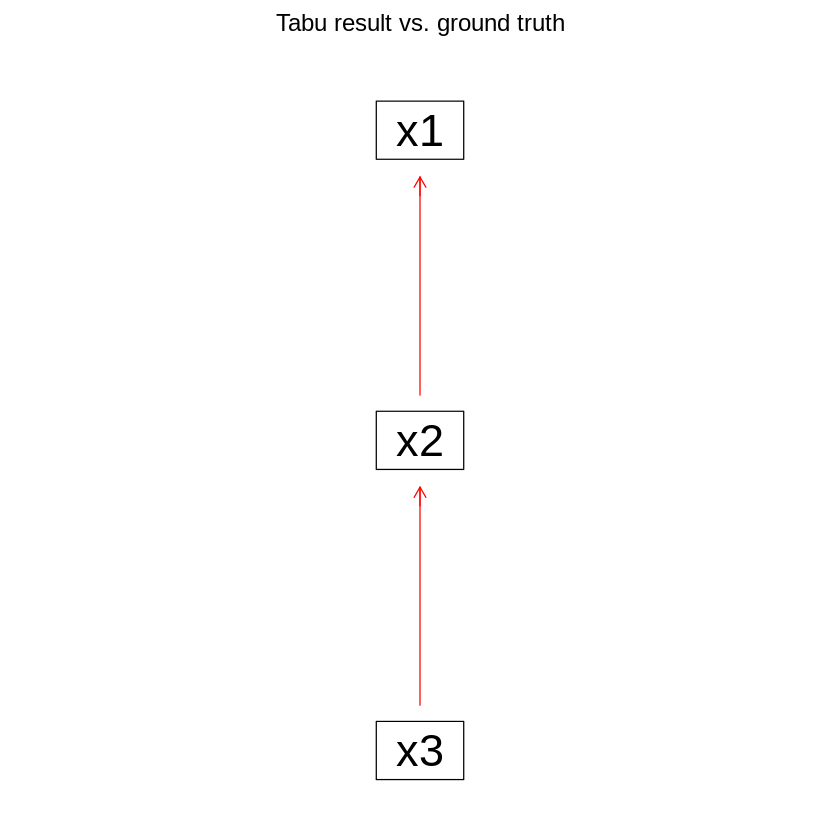

In [ ]:
# use tabu bnlearn
k2_model_ruiz <- tabu(data_ruiz, score = "k2", maxp=max_parents)
#k2_model_ruiz <- hc(ruiz, score = "k2", maxp = max_parents) #hill climbing

# Plot the learned structure & compare to ground truth
graphviz.compare(dag_ruiz, k2_model_ruiz, main=c("Ground truth","Tabu result vs. ground truth"))

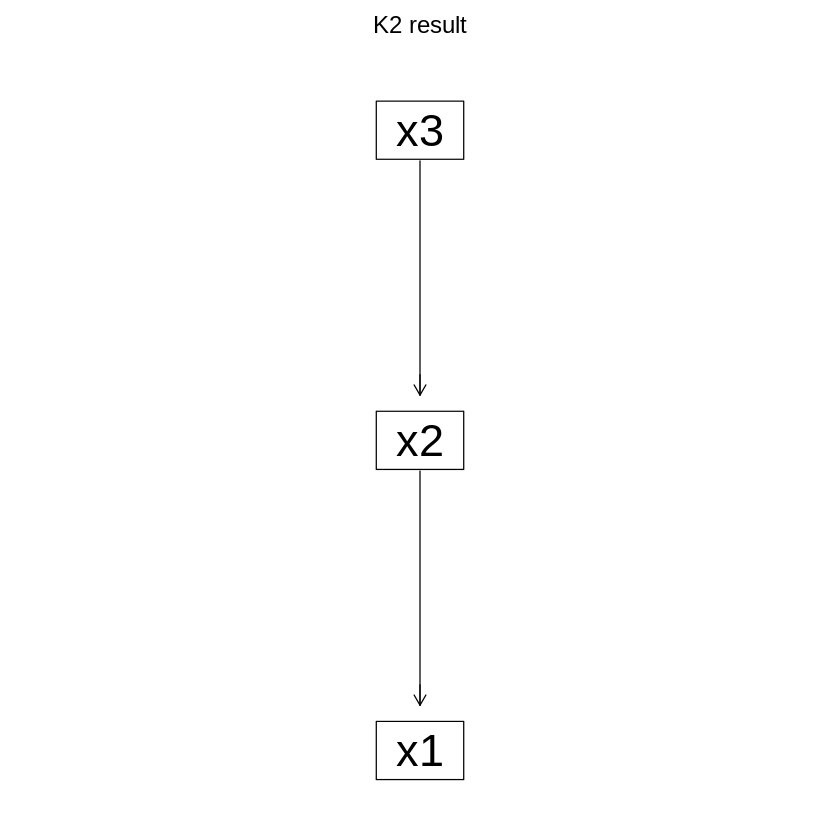

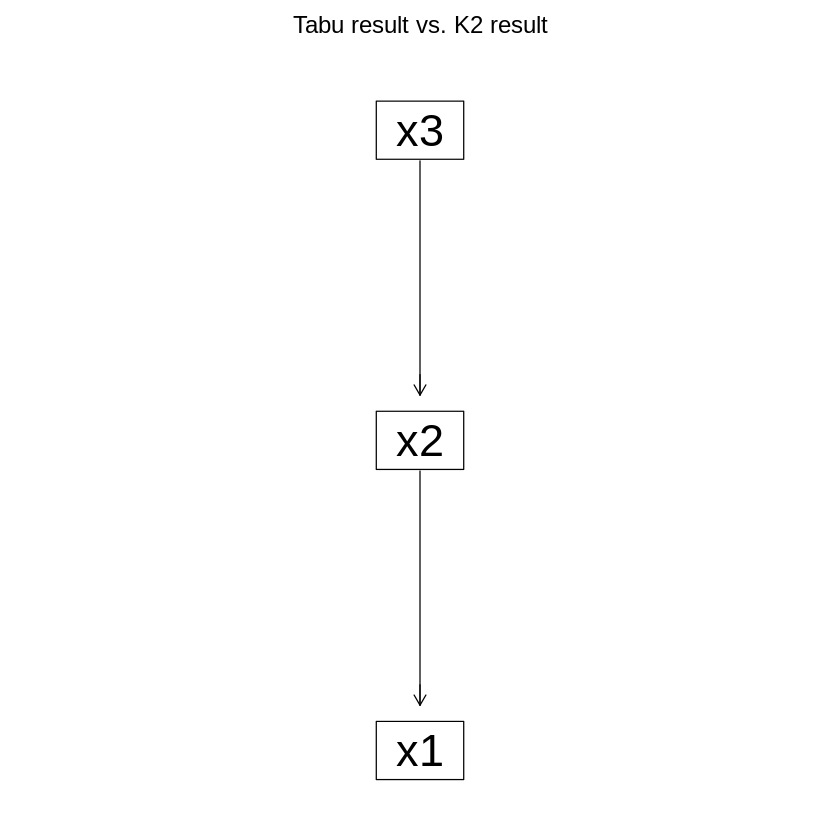

In [ ]:
# compare K2 and tabu results to each other
graphviz.compare(bn_k2_ruiz, k2_model_ruiz, main=c("K2 result","Tabu result vs. K2 result"))

### ASIA dataset

The ASIA dataset is a synthetic dataset about lung diseases from [[Lauritzen/Spiegelhalter 1988]](https://doi.org/10.1111/j.2517-6161.1988.tb01721.x). It is included in the `bnlearn` library and contains the following (2-level factor) attributes:
- `D` (dyspnoea)
- `T` (tuberculosis)
- `L` (lung cancer)
- `B` (bronchitis)
- `A` (visit to Asia)
- `S` (smoking)
- `X` (chest X-ray)
- `E` (tuberculosis or lung cancer/bronchitis)


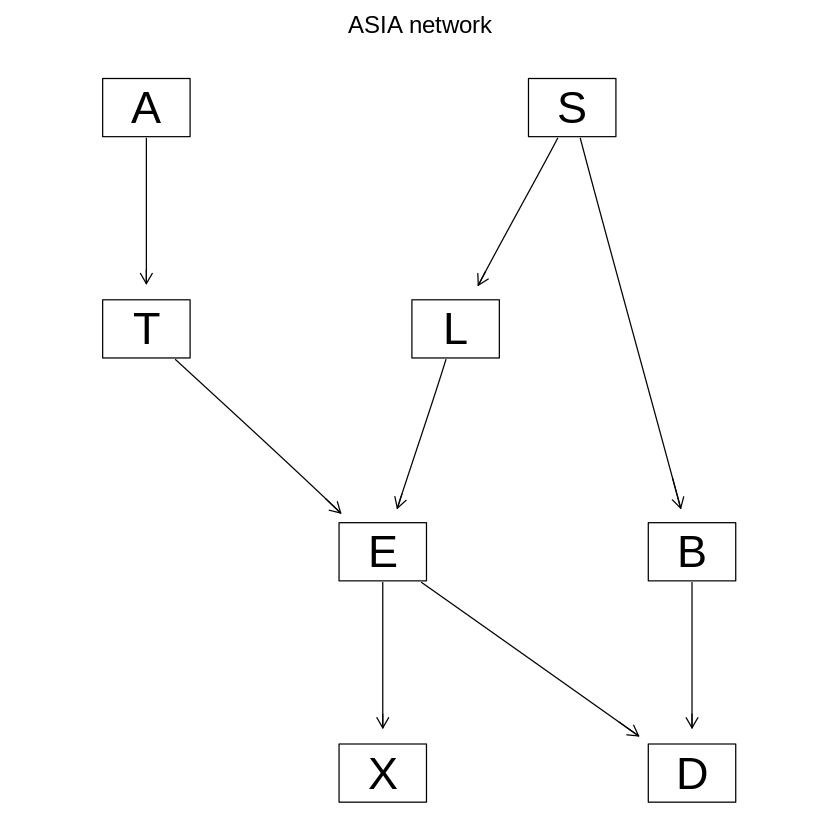

In [ ]:
# load data
data(asia)

# ground truth network structure.
dag_asia = model2network("[A][S][T|A][L|S][B|S][D|B:E][E|T:L][X|E]")

# Define the node order for the Asia dataset
node_order_asia <- colnames(asia)

#plot
graphviz.plot(dag_asia,main="ASIA network")

In [ ]:
# use self-implemented K2 algorithm with randomized node orderings
results <- rsearch(data=asia, node_order=node_order_asia, t=300)
scores <- results$score
bn_k2_asia <- results$bn

Running iteration # 1 ...
Running iteration # 2 ...
Running iteration # 3 ...
Running iteration # 4 ...
Running iteration # 5 ...
Running iteration # 6 ...
Running iteration # 7 ...
Running iteration # 8 ...
Running iteration # 9 ...
Running iteration # 10 ...
Running iteration # 11 ...
Running iteration # 12 ...
Running iteration # 13 ...
Running iteration # 14 ...
Running iteration # 15 ...
Running iteration # 16 ...
Running iteration # 17 ...
Running iteration # 18 ...
Running iteration # 19 ...
Running iteration # 20 ...
Running iteration # 21 ...
Running iteration # 22 ...
Running iteration # 23 ...
Running iteration # 24 ...
Running iteration # 25 ...
Running iteration # 26 ...
Running iteration # 27 ...
Running iteration # 28 ...
Running iteration # 29 ...
Running iteration # 30 ...
Running iteration # 31 ...
Running iteration # 32 ...
Running iteration # 33 ...
Running iteration # 34 ...
Running iteration # 35 ...
Running iteration # 36 ...
Running iteration # 37 ...
Running it

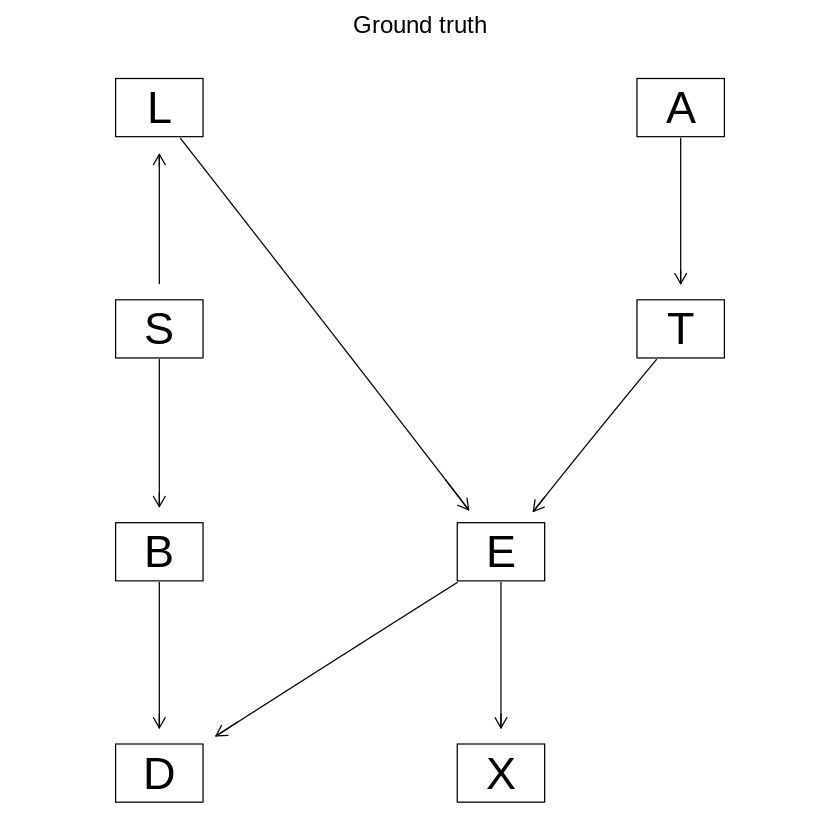

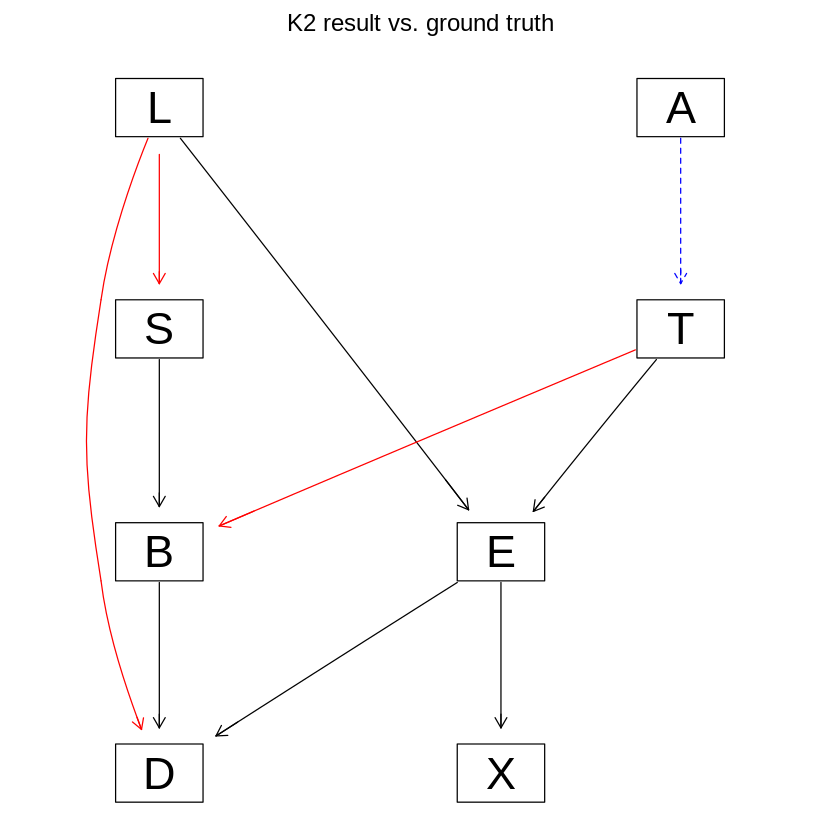

In [ ]:
# plot & compare to ground truth
graphviz.compare(dag_asia, bn_k2_asia, main=c("Ground truth", "K2 result vs. ground truth"))

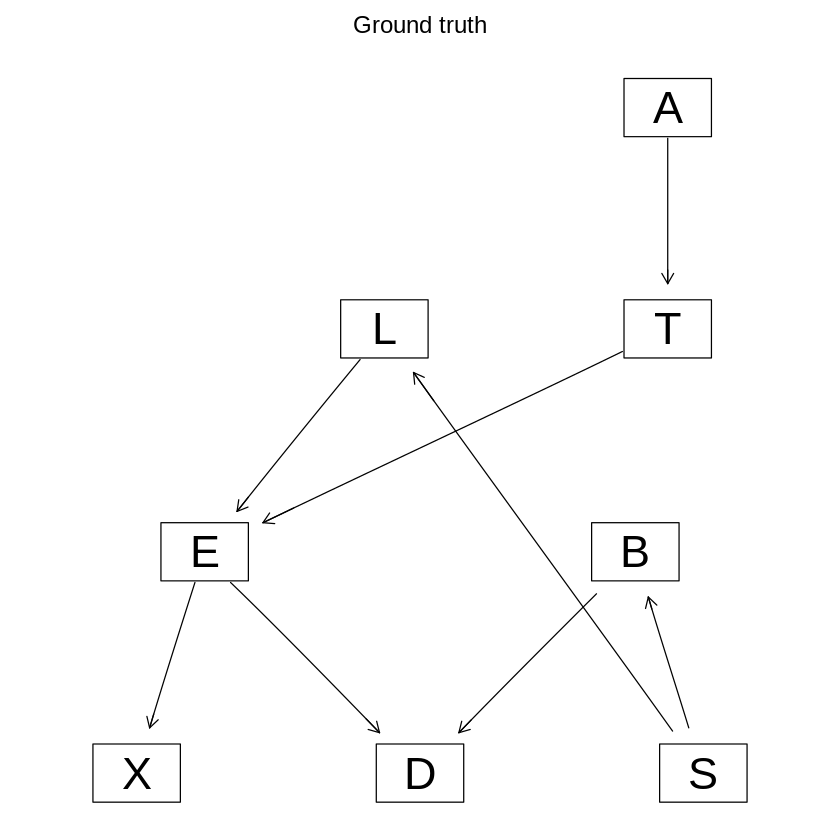

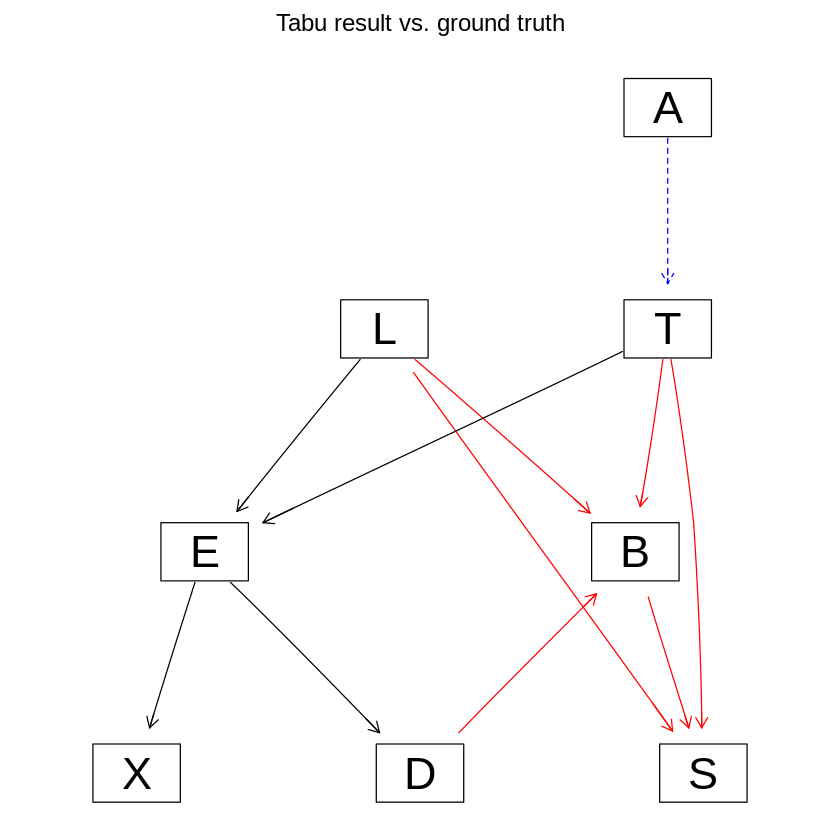

In [ ]:
# use tabu bnlearn

#k2_model_asia <- hc(asia, score = "k2", maxp = max_parents)
k2_model_asia <- tabu(asia, score="k2", maxp=max_parents)

# plot & compare to ground truth
graphviz.compare(dag_asia, k2_model_asia, main=c("Ground truth", "Tabu result vs. ground truth"))

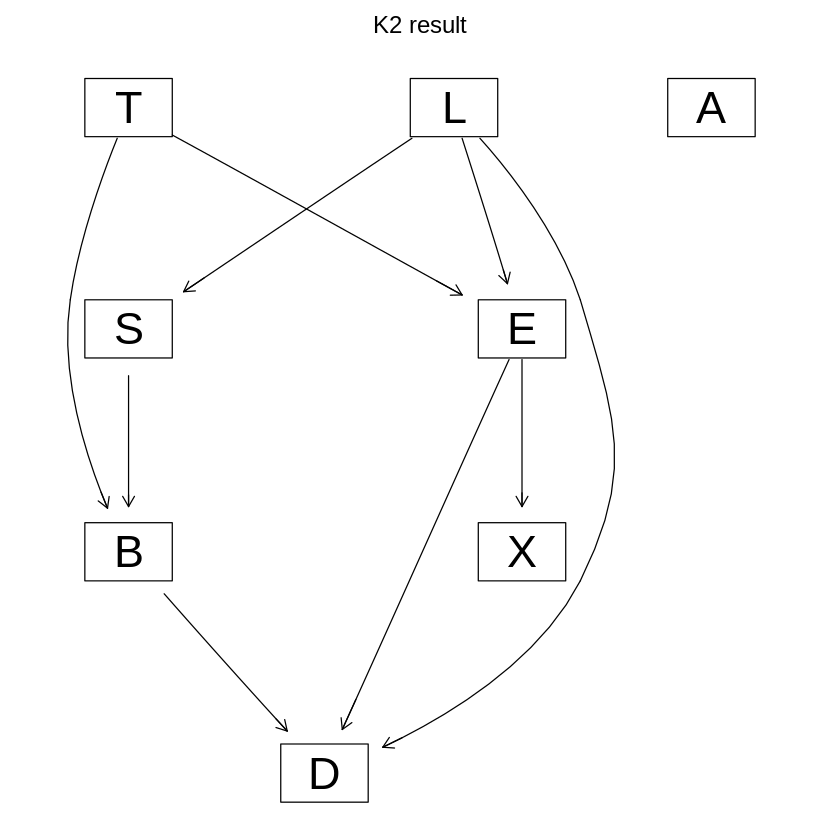

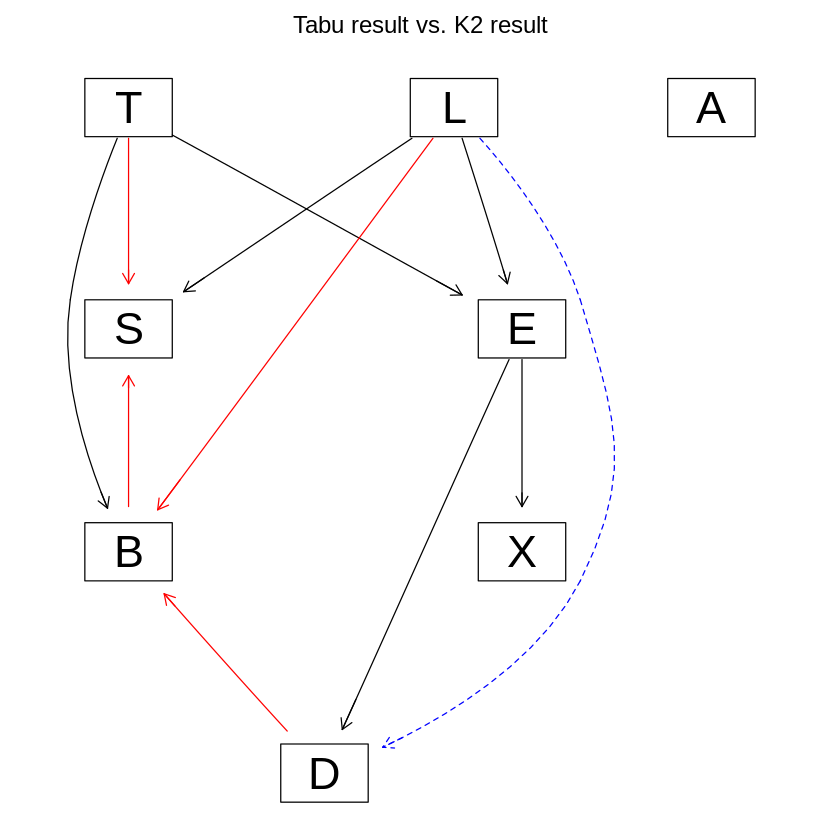

In [ ]:
# compare K2 and tabu results to each other
graphviz.compare(bn_k2_asia, k2_model_asia, main=c("K2 result","Tabu result vs. K2 result"))

### CHILD dataset
The CHILD Dataset [[Spiegelhalter/Cowell 1992]](https://doi.org/10.1093/oso/9780198522669.003.0025) is a medical dataset about congenital conditions potentially leading to a "blue" baby. It consists of 20 attributes:
- `BirthAsphyxia` levels: 1 2
- `Disease` levels: 1 2 3 4 5
- `Sick` levels: 1 2
- `DuctFlow` levels: 1 2 3
- `CardiacMixing` levels: 1 2 3 4
- `LungParench` levels: 1 2 3
- `LungFlow` levels: 1 2 3
- `LVH` levels: 1 2
- `Age` levels: 1 2 3
- `Grunting` levels: 1 2
- `HypDistrib` levels: 1 2
- `HypoxiaInO2` levels: 1 2 3
- `CO2` levels: 1 2 3
- `ChestXray` levels: 1 2 3 4 5
- `LVHreport` levels: 1 2
- `GruntingReport` levels: 1 2
- `LowerBodyO2` levels: 1 2 3
- `RUQO2` levels: 1 2 3
- `CO2Report` levels: 1 2
- `XrayReport` levels: 1 2 3 4 5



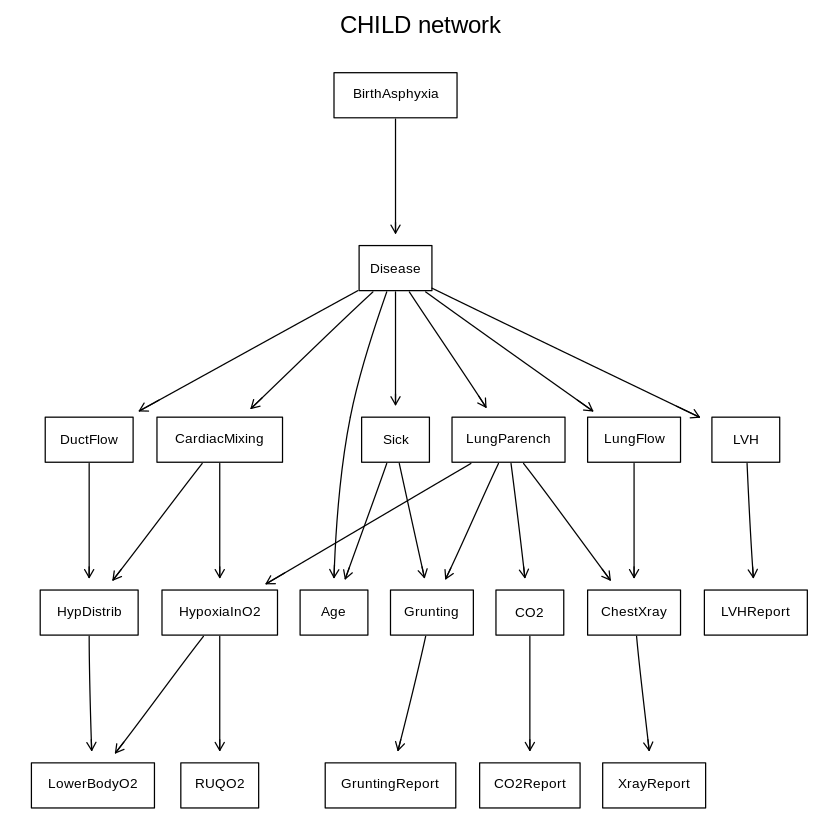

In [ ]:
# load CHILD dataset & convert to data.frame
dataset <- child()
child.df <- dataset %>%
    raw.data() %>%
    as.data.frame() %>% # convert to data.frame
    mutate(across(everything(), ~ replace_na(as.character(.), "NA"))) %>% # replace NA values with "NA"
    mutate(across(everything(), ~as.factor(.))) # convert all vars to factors
colnames(child.df) <- variables(dataset)

# ground truth network structure.
dag_child = model2network("[BirthAsphyxia][Disease|BirthAsphyxia][Sick|Disease][DuctFlow|Disease][CardiacMixing|Disease][LungParench|Disease][LungFlow|Disease][LVH|Disease][Age|Disease:Sick][Grunting|Sick:LungParench][HypDistrib|CardiacMixing:DuctFlow][HypoxiaInO2|CardiacMixing:LungParench][CO2|LungParench][ChestXray|LungParench:LungFlow][LVHReport|LVH][GruntingReport|Grunting][LowerBodyO2|HypDistrib:HypoxiaInO2][RUQO2|HypoxiaInO2][CO2Report|CO2][XrayReport|ChestXray]")

# Define the node order for the Child dataset
node_order_child <- colnames(child.df)

# plot gorund truth
graphviz.plot(dag_child, main="CHILD network")

In [ ]:
# use self-implemented K2 algorithm with randomized node orderings
results <- rsearch(child.df, node_order_child, t=300)
scores <- results$scores
bn_k2_child <- results$bn

Running iteration # 1 ...
Running iteration # 2 ...
Running iteration # 3 ...
Running iteration # 4 ...
Running iteration # 5 ...
Running iteration # 6 ...
Running iteration # 7 ...
Running iteration # 8 ...
Running iteration # 9 ...
Running iteration # 10 ...
Running iteration # 11 ...
Running iteration # 12 ...
Running iteration # 13 ...
Running iteration # 14 ...
Running iteration # 15 ...
Running iteration # 16 ...
Running iteration # 17 ...
Running iteration # 18 ...
Running iteration # 19 ...
Running iteration # 20 ...
Running iteration # 21 ...
Running iteration # 22 ...
Running iteration # 23 ...
Running iteration # 24 ...
Running iteration # 25 ...
Running iteration # 26 ...
Running iteration # 27 ...
Running iteration # 28 ...
Running iteration # 29 ...
Running iteration # 30 ...
Running iteration # 31 ...
Running iteration # 32 ...
Running iteration # 33 ...
Running iteration # 34 ...
Running iteration # 35 ...
Running iteration # 36 ...
Running iteration # 37 ...
Running it

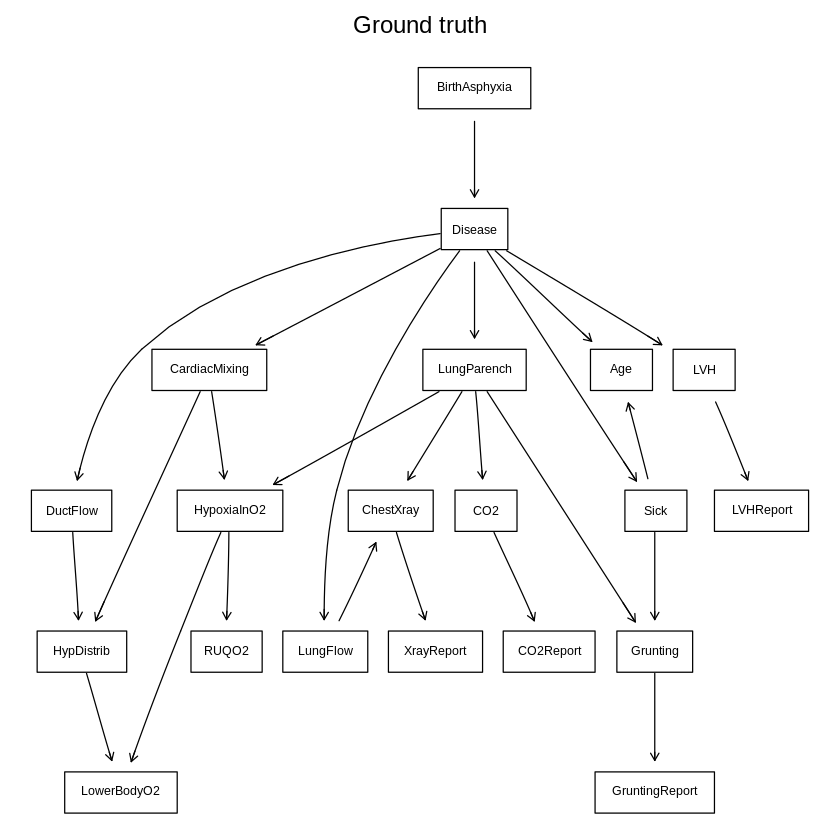

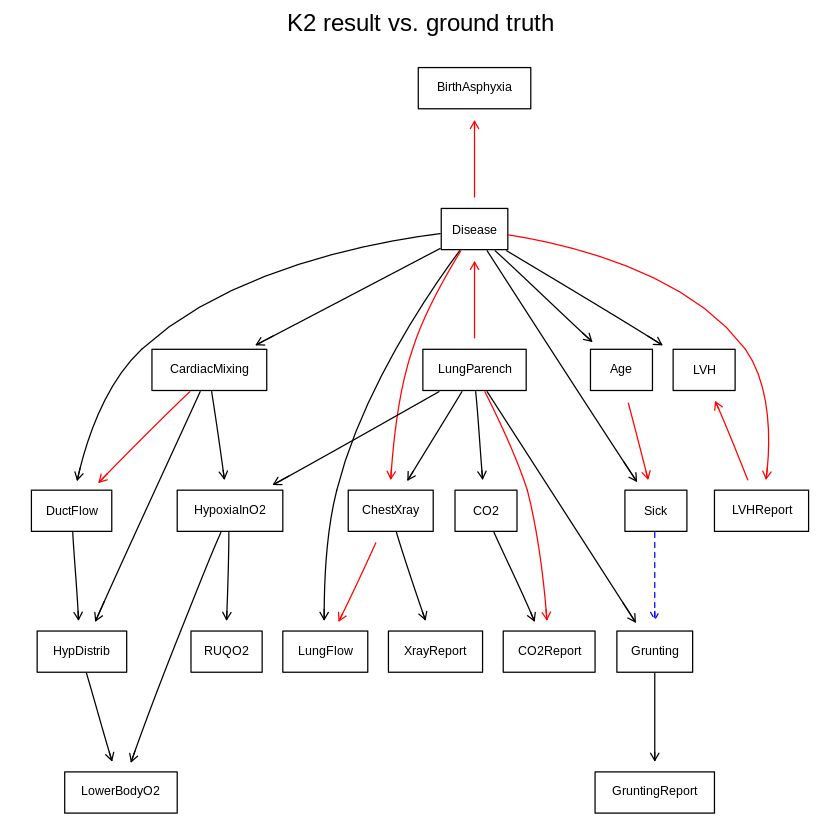

In [ ]:
# plot & compare to ground truth
graphviz.compare(dag_child, bn_k2_child, main=c("Ground truth","K2 result vs. ground truth"))

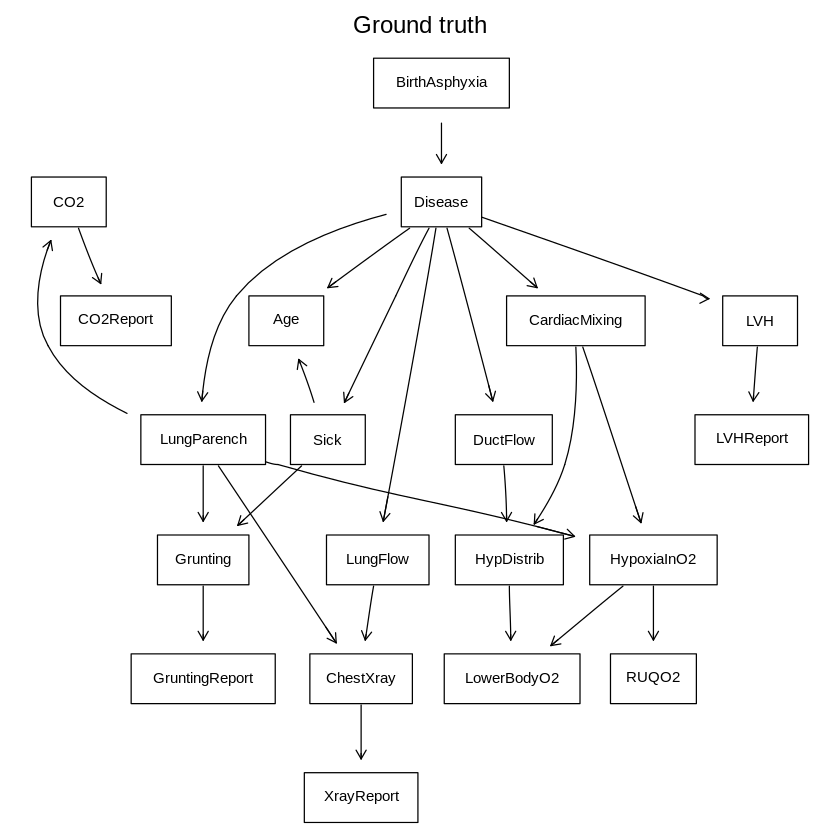

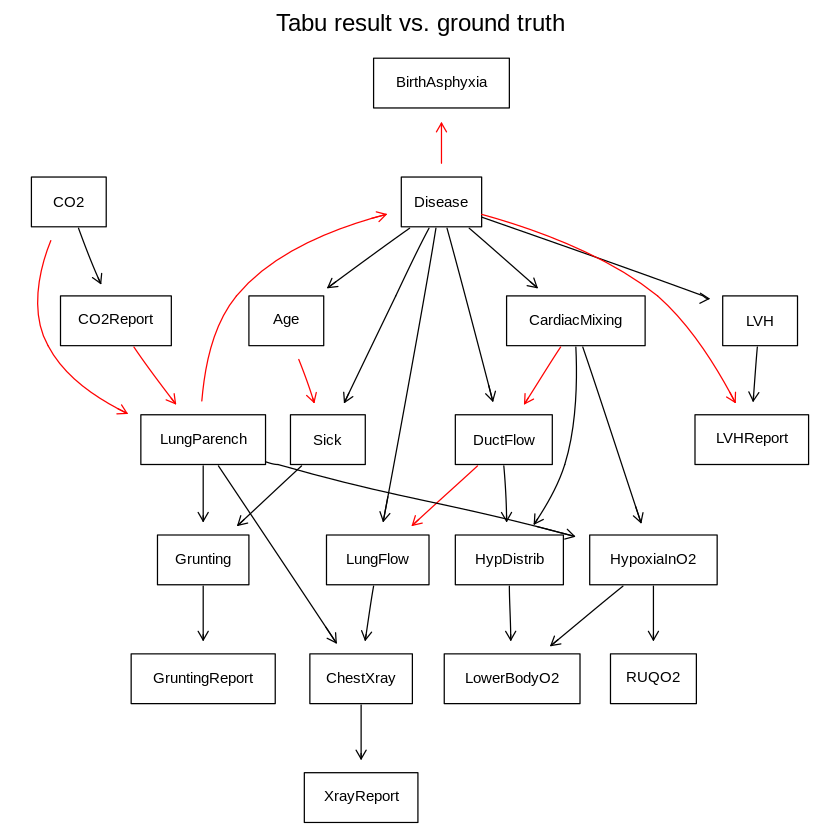

In [ ]:
# use tabu bnlearn
k2_model_child <- tabu(child.df, score="k2", maxp=max_parents)
#k2_model_child <- hc(child, score="k2", maxp=max_parents)

# plot & compare to ground truth
graphviz.compare(dag_child, k2_model_child, main=c("Ground truth","Tabu result vs. ground truth"))

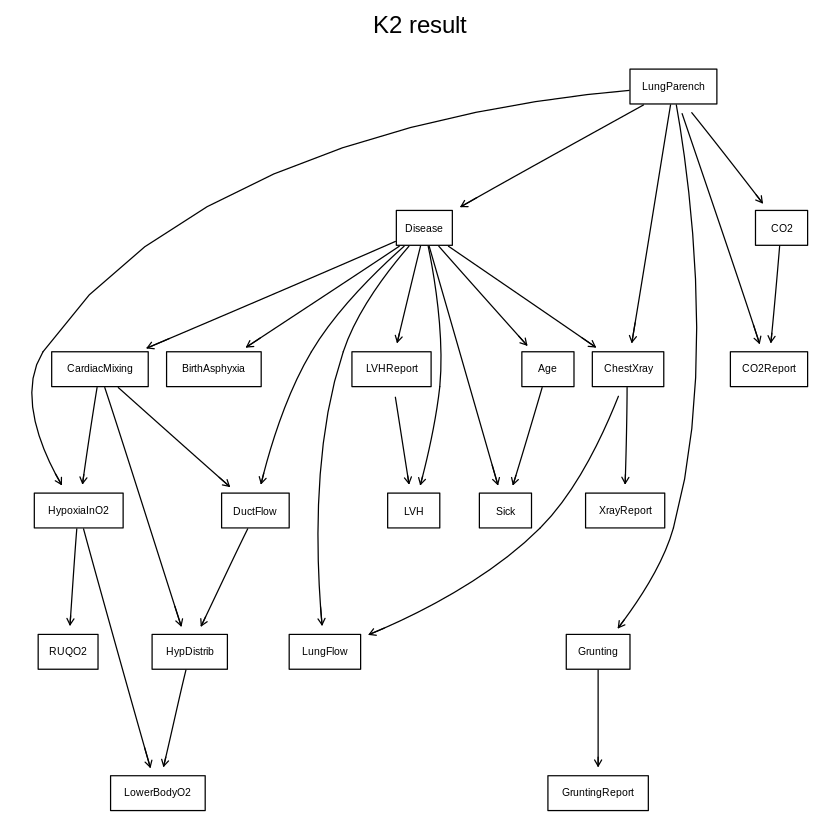

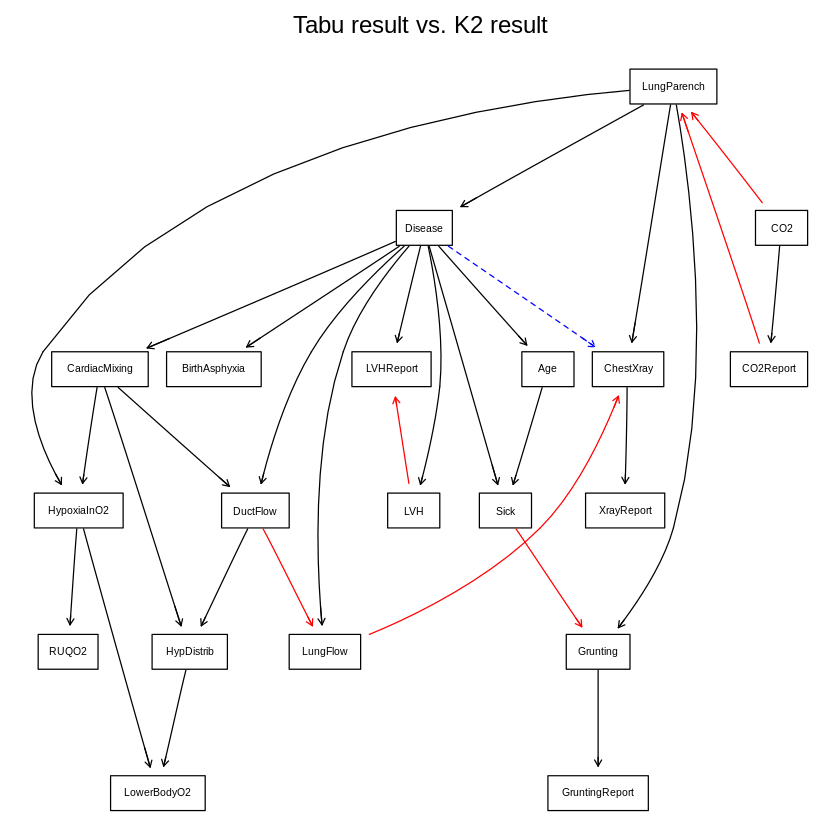

In [ ]:
# compare K2 and tabu results to each other
graphviz.compare(bn_k2_child, k2_model_child, main=c("K2 result","Tabu result vs. K2 result"))

## Heart Disease Dataset

The [UCI Heart Disease Dataset](https://doi.org/10.24432/C52P4X) contains attributes that are considered relevant for predicting heart disease in patients. The attributes are listed  below:

1. `id` (Unique id for each patient)
2. `age` (Age of the patient in years)
3. `origin` (place of study)
4. `sex` (Male/Female)
5. `cp` chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
6. `trestbps` resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
7. `chol` (serum cholesterol in mg/dl)
8. `fbs` (if fasting blood sugar > 120 mg/dl)
9. `restecg` (resting electrocardiographic results) --  Values: [normal, stt abnormality, lv hypertrophy]
10. `thalach`: maximum heart rate achieved
11. `exang` exercise-induced angina (True/ False)
12. `oldpeak` ST depression induced by exercise relative to rest
13. `slope` the slope of the peak exercise ST segment
14. `ca`: number of major vessels (0-3) colored by fluoroscopy
15. `thal`: [normal; fixed defect; reversible defect]
16. `num`: the predicted attribute

Note that `id` and `origin` were excluded from the analysis, as they are assumed to be irrelevant for the presence of heart disease.


In [ ]:
# import & data preparations

# load the dataset
data <- read.csv("heart_disease_uci.csv")

# preprocess the data
heart <- data %>%
    select(-id, -dataset) %>% # remove id and dataset column
    mutate(across(c(age, trestbps, chol, thalch, oldpeak), ~ arules::discretize(., method = "interval", breaks = 3))) %>% # discretize continuous variables
    mutate(across(everything(), ~ replace_na(as.character(.), "NA"))) %>% # replace NA values with "NA"
    mutate(across(everything(), as.factor)) # convert all columns to factor type

# verify preprocessing results
summary(heart)

          age          sex                    cp            trestbps  
 [28,44.3)  :178   Female:194   asymptomatic   :496   [0,66.7)  :  1  
 [44.3,60.7):521   Male  :726   atypical angina:174   [133,200] :361  
 [60.7,77]  :221                non-anginal    :204   [66.7,133):499  
                                typical angina : 46   NA        : 59  
                                                                      
        chol        fbs                  restecg          thalch      exang    
 [0,201)  :304   FALSE:692                   :  2   [107,155):509   FALSE:528  
 [201,402):573   NA   : 90   lv hypertrophy  :188   [155,202]:245   NA   : 55  
 [402,603]: 13   TRUE :138   normal          :551   [60,107) :111   TRUE :337  
 NA       : 30               st-t abnormality:179   NA       : 55              
                                                                               
         oldpeak            slope      ca                     thal     num    
 [-2.6,0.333):4

In [ ]:
# use self-implemented K2 algorithm with randomized node orderings
node_order_h <- colnames(heart)
results <- rsearch(heart, node_order_h, t=1000)
scores <- results$scores
bn_k2_heart <- results$bn

Running iteration # 1 ...
Running iteration # 2 ...
Running iteration # 3 ...
Running iteration # 4 ...
Running iteration # 5 ...
Running iteration # 6 ...
Running iteration # 7 ...
Running iteration # 8 ...
Running iteration # 9 ...
Running iteration # 10 ...
Running iteration # 11 ...
Running iteration # 12 ...
Running iteration # 13 ...
Running iteration # 14 ...
Running iteration # 15 ...
Running iteration # 16 ...
Running iteration # 17 ...
Running iteration # 18 ...
Running iteration # 19 ...
Running iteration # 20 ...
Running iteration # 21 ...
Running iteration # 22 ...
Running iteration # 23 ...
Running iteration # 24 ...
Running iteration # 25 ...
Running iteration # 26 ...
Running iteration # 27 ...
Running iteration # 28 ...
Running iteration # 29 ...
Running iteration # 30 ...
Running iteration # 31 ...
Running iteration # 32 ...
Running iteration # 33 ...
Running iteration # 34 ...
Running iteration # 35 ...
Running iteration # 36 ...
Running iteration # 37 ...
Running it

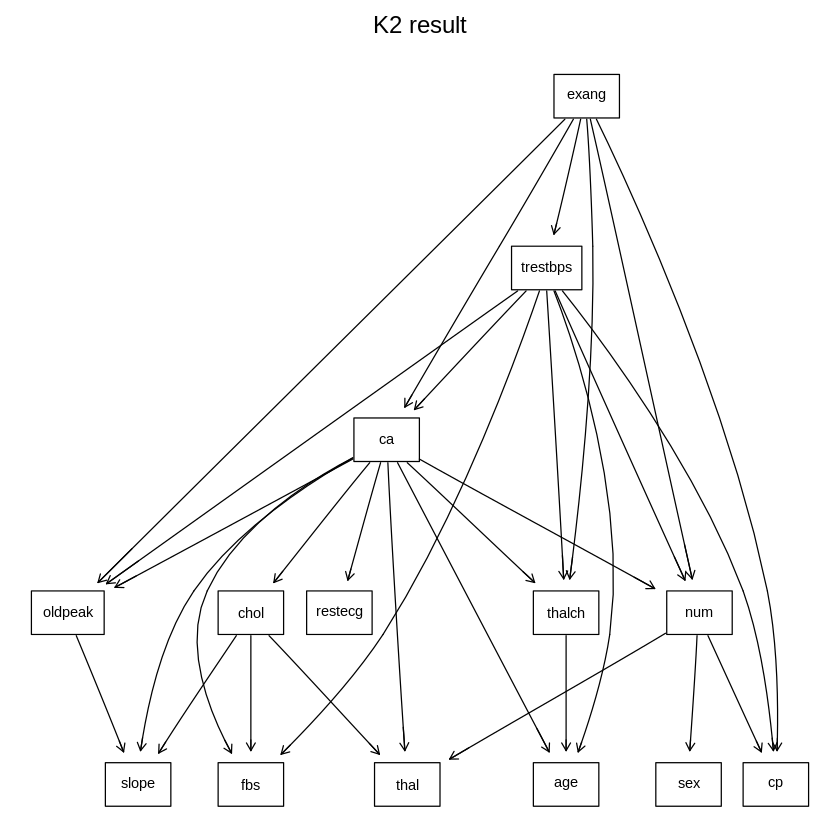

In [ ]:
# plot resulting graph
graphviz.plot(bn_k2_heart, main="K2 result")
#Unknown-3.png:

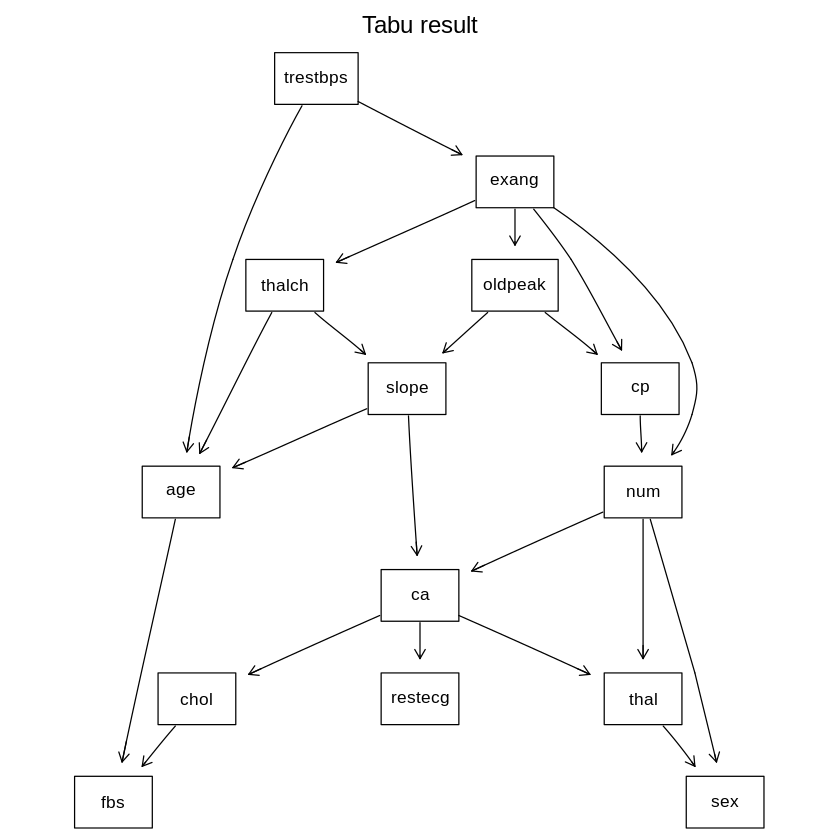

In [ ]:
# use tabu bnlearn
k2_model_heart <- tabu(heart, score="k2", maxp=max_parents)
#k2_model_heart <- hc(heart, score="k2", maxp=max_parents)

# plot result
graphviz.plot(k2_model_heart, main=c("Tabu result"))
#Unknown-4.png:

In [ ]:
# compare K2 and tabu result:
graphviz.compare(bn_k2_heart, k2_model_heart, main=c("K2 result", "Tabu result vs. K2 result"))

ERROR: Error in eval(expr, envir, enclos): object 'bn_k2_heart' not found


#### Curating node orders via blacklist & whitelist

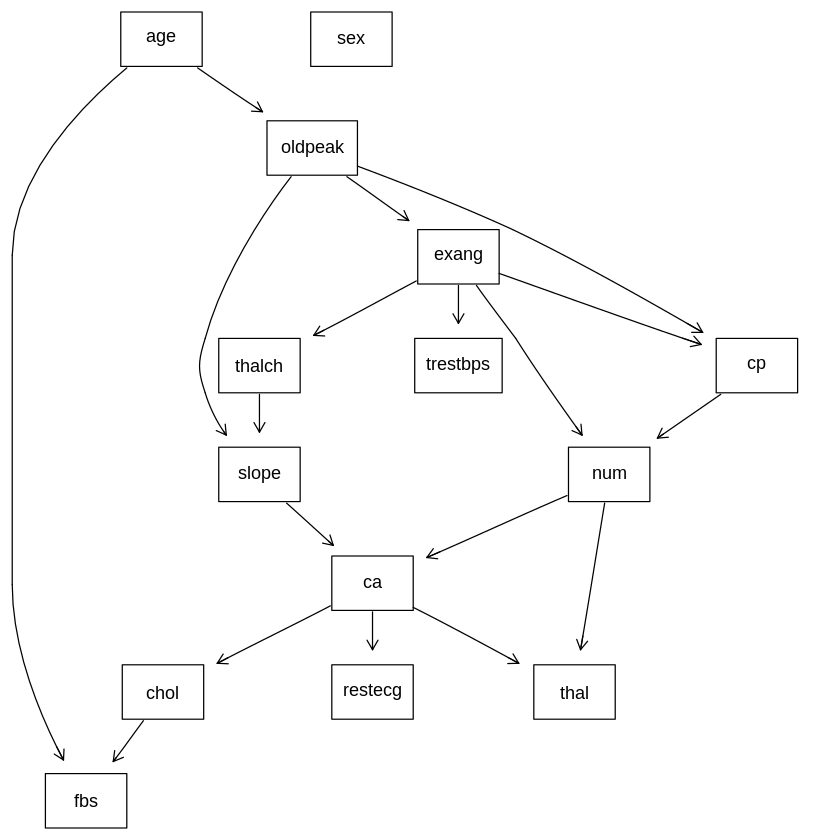

In [ ]:
node_order <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalch", "exang", "oldpeak", "slope", "ca", "thal", "num")

# Create a whitelist based on node order

# Convert to matrix with appropriate column names

# Define blacklist to prevent age and sex from being parents of each other
blacklist <- matrix(c("age", "sex",
                      "sex", "age",
                      "cp", "sex",
                      "cp", "age",
                      "trestbps", "age",
                      "trestbps", "sex",
                      "chol", "age",
                      "chol", "sex",
                      "fbs", "age",
                      "fbs", "sex",
                      "restecg", "age",
                      "restecg", "sex",
                      "thalch", "age",
                      "thalch", "sex",
                      "exang", "age",
                      "exang", "sex",
                      "oldpeak", "age",
                      "oldpeak", "sex",
                      "slope", "age",
                      "slope", "sex",
                      "ca", "age",
                      "ca", "sex",
                      "thal", "age",
                      "thal", "sex",
                      "num", "age",
                      "num", "sex"),
                    byrow = TRUE, ncol = 2)

#colnames(blacklist) <- c("from", "to")
# Learn the structure using the K2 algorithm
#k2_model_heart <- hc(heart, score = "k2", maxp = max_parents)
#k2_model_heart <- hc(heart, score = "k2", maxp = max_parents, whitelist = whitelist, blacklist = blacklist)
k2_model_heart_blacklist <- tabu(heart, score = "k2", blacklist = blacklist)

graphviz.plot(k2_model_heart_blacklist)

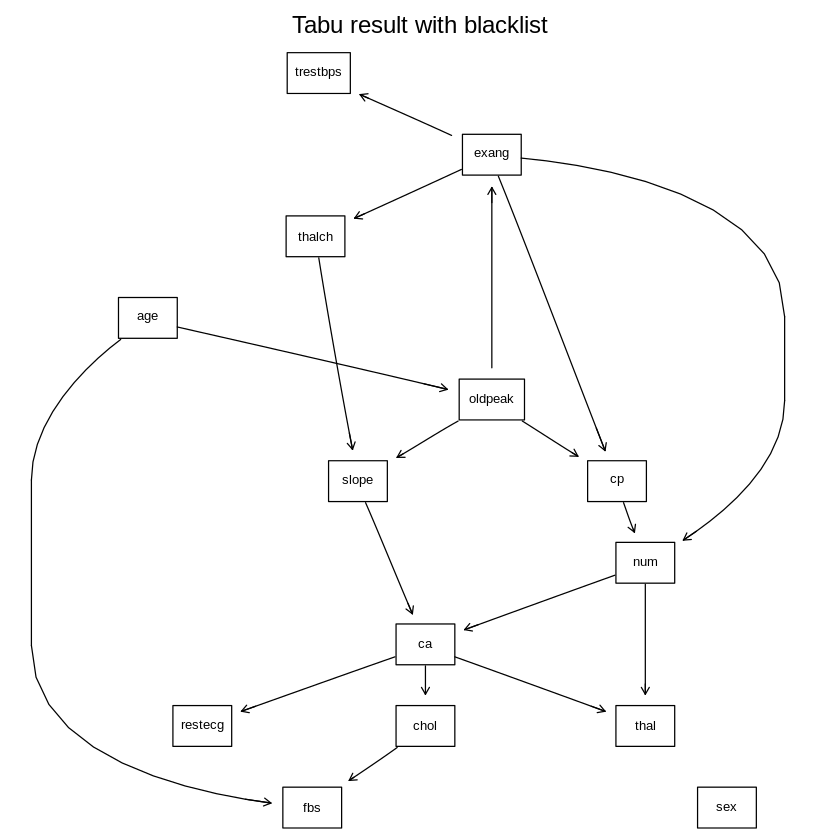

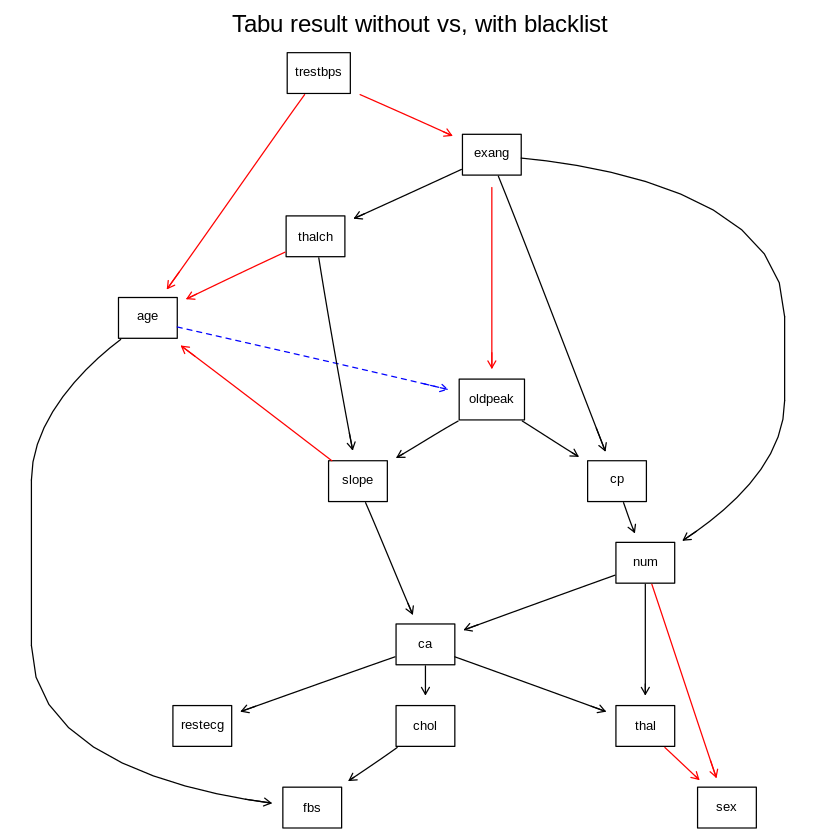

In [ ]:
# plot
graphviz.compare(k2_model_heart_blacklist, k2_model_heart, main=c("Tabu result with blacklist", "Tabu result without vs, with blacklist"))
#Unknown-8.png and Unknown-9.png

In [ ]:
print(bn_k2_heart)

In [ ]:
# Print the levels for each column in the preprocessed data
print(sapply(heart, levels))


$age
[1] "[28,44.3)"   "[44.3,60.7)" "[60.7,77]"  

$sex
[1] "Female" "Male"  

$cp
[1] "asymptomatic"    "atypical angina" "non-anginal"     "typical angina" 

$trestbps
[1] "[0,66.7)"   "[133,200]"  "[66.7,133)" "NA"        

$chol
[1] "[0,201)"   "[201,402)" "[402,603]" "NA"       

$fbs
[1] "FALSE" "NA"    "TRUE" 

$restecg
[1] ""                 "lv hypertrophy"   "normal"           "st-t abnormality"

$thalch
[1] "[107,155)" "[155,202]" "[60,107)"  "NA"       

$exang
[1] "FALSE" "NA"    "TRUE" 

$oldpeak
[1] "[-2.6,0.333)" "[0.333,3.27)" "[3.27,6.2]"   "NA"          

$slope
[1] ""            "downsloping" "flat"        "upsloping"  

$ca
[1] "0"  "1"  "2"  "3"  "NA"

$thal
[1] ""                  "fixed defect"      "normal"           
[4] "reversable defect"

$num
[1] "0" "1" "2" "3" "4"



In [ ]:
# Construct evidence based on the valid levels in the preprocessed data
evidence_df <- data.frame(
  age = "[44.3,60.7)", # Match levels printed above
  sex = "Male",
  cp = "typical angina",
  trestbps = "[133,200]", # Match levels printed above
  chol = "[201,402)", # Match levels printed above
  thalach = "[107,155)", # Match levels printed above
  oldpeak = "[0.333,3.27)" # Match levels printed above
)
# Fit the Bayesian network
bn_k2_heart2 <- bn.fit(bn_k2_heart, data = heart)
# Ensure the evidence matches the dataset columns
colnames(evidence_df) <- c("age", "sex", "cp", "trestbps", "chol", "thalch", "oldpeak")

# Use the cpquery function to make a prediction for the node 'num'
set.seed(123)  # For reproducibility
prediction <- cpquery(fitted = bn_k2_heart2, event = (num == "0"), evidence = as.list(evidence_df), method = "lw")
print(prediction)

[1] 0.4659396


In [ ]:
# Construct evidence based on the valid levels in the preprocessed data
evidence_df <- data.frame(
  age = "[44.3,60.7)", # Match levels printed above
  sex = "Male",
  cp = "typical angina",
  trestbps = "[133,200]", # Match levels printed above
  chol = "[201,402)", # Match levels printed above
  thalach = "[107,155)", # Match levels printed above
  oldpeak = "[0.333,3.27)" # Match levels printed above
)

# Ensure the evidence matches the dataset columns
colnames(evidence_df) <- c("age", "sex", "cp", "trestbps", "chol", "thalch", "oldpeak")

# Function to generate predictions
generate_predictions <- function(fitted_model, evidence, n_runs) {
  predictions <- numeric(n_runs)
  for (i in 1:n_runs) {
    if (i %% 2 == 0) {
      set.seed(i)  # Set a seed for reproducibility
    } else {
      set.seed(NULL)  # No seed for variability
    }
    predictions[i] <- cpquery(fitted = fitted_model, event = (num == "0"), evidence = as.list(evidence), method = "lw")
  }
  return(predictions)
}

# Generate predictions
n_runs <- 10
predictions <- generate_predictions(bn_k2_heart2, evidence_df, n_runs)

# Create a data frame with the predictions
prediction_df <- data.frame(
  Run = 1:n_runs,
  Prediction = predictions
)

# Print the data frame
print(prediction_df)

# Calculate and print the error (standard deviation)
prediction_error <- sd(predictions)
cat("Prediction Error (Standard Deviation):", prediction_error, "\n")

   Run Prediction
1    1  0.4612185
2    2  0.4792909
3    3  0.4661384
4    4  0.4642602
5    5  0.4758315
6    6  0.4630141
7    7  0.4677808
8    8  0.4804520
9    9  0.4584421
10  10  0.4683893
Prediction Error (Standard Deviation): 0.007611406 


In [ ]:
# Define multiple evidence data frames based on the valid levels in the preprocessed data
evidence_list <- list(
  data.frame(
    age = "[44.3,60.7)",
    sex = "Male",
    cp = "typical angina",
    trestbps = "[133,200]",
    chol = "[201,402)",
    thalach = "[107,155)",
    oldpeak = "[0.333,3.27)"
  ),
  data.frame(
    age = "[44.3,60.7)",
    sex = "Female",
    cp = "typical angina",
    trestbps = "[133,200]",
    chol = "[201,402)",
    thalach = "[107,155)",
    oldpeak = "[0.333,3.27)"
  ),
  data.frame(
    age = "[44.3,60.7)",
    sex = "Male",
    cp = "asymptomatic",
    trestbps = "[133,200]",
    chol = "[201,402)",
    thalach = "[107,155)",
    oldpeak = "[0.333,3.27)"
  )
)

# Ensure the evidence matches the dataset columns
for (i in 1:length(evidence_list)) {
  colnames(evidence_list[[i]]) <- c("age", "sex", "cp", "trestbps", "chol", "thalch", "oldpeak")
}

# Function to generate predictions for multiple evidence scenarios
generate_predictions_for_evidence <- function(fitted_model, evidence_list, n_runs_per_evidence) {
  results <- data.frame()
  for (i in 1:length(evidence_list)) {
    evidence <- evidence_list[[i]]
    predictions <- numeric(n_runs_per_evidence)
    for (j in 1:n_runs_per_evidence) {
      if (j %% 2 == 0) {
        set.seed(j)  # Set a seed for reproducibility
      } else {
        set.seed(NULL)  # No seed for variability
      }
      predictions[j] <- cpquery(fitted = fitted_model, event = (num == "0"), evidence = as.list(evidence), method = "lw")
    }
    evidence_name <- paste("Evidence", i, sep = "_")
    results <- rbind(results, data.frame(Evidence = evidence_name, Run = 1:n_runs_per_evidence, Prediction = predictions))
  }
  return(results)
}

# Generate predictions for multiple evidence scenarios
n_runs_per_evidence <- 100
prediction_df <- generate_predictions_for_evidence(bn_k2_heart2, evidence_list, n_runs_per_evidence)

# Print the data frame with the predictions
print(prediction_df)

# Calculate and print the error (standard deviation) for each evidence scenario
prediction_errors <- prediction_df %>%
  group_by(Evidence) %>%
  summarise(Error = sd(Prediction))

print(prediction_errors)

      Evidence Run Prediction
1   Evidence_1   1 0.46516568
2   Evidence_1   2 0.47929091
3   Evidence_1   3 0.46112175
4   Evidence_1   4 0.46426023
5   Evidence_1   5 0.48033509
6   Evidence_1   6 0.46301409
7   Evidence_1   7 0.46659692
8   Evidence_1   8 0.48045201
9   Evidence_1   9 0.45612278
10  Evidence_1  10 0.46838932
11  Evidence_1  11 0.47790372
12  Evidence_1  12 0.46900765
13  Evidence_1  13 0.46126936
14  Evidence_1  14 0.45719833
15  Evidence_1  15 0.46767321
16  Evidence_1  16 0.46578449
17  Evidence_1  17 0.46426838
18  Evidence_1  18 0.46926098
19  Evidence_1  19 0.47497847
20  Evidence_1  20 0.46896792
21  Evidence_1  21 0.46690913
22  Evidence_1  22 0.47260920
23  Evidence_1  23 0.46663831
24  Evidence_1  24 0.47604645
25  Evidence_1  25 0.46833498
26  Evidence_1  26 0.45734359
27  Evidence_1  27 0.45694479
28  Evidence_1  28 0.46764195
29  Evidence_1  29 0.46198039
30  Evidence_1  30 0.46606278
31  Evidence_1  31 0.46869941
32  Evidence_1  32 0.47279451
33  Eviden